<a href="https://colab.research.google.com/github/sv650s/sb-capstone2/blob/master/notebooks/9.2-atp_nn_1layer_2xfeatures_diff_ohe_history_matchup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ATP Tennis Data - NN Using One Hot Encoding

In this notebook, I created a neural network with dataset where player stats are diff'd and we one hot encoded all non-ordinal categorical data - ie, player origin, player id, tournament id, etc

Initially I had created a 2 layer NN each layer with 3 x number of features (~5k), but the kernel kept crasing on Google Colab so I decided to reduce this to a 1 layer NN with 2 x number of features

# Result

This did much better than the 2 layer network using the player diff dataset. We achieved ~80% accuracy.

Still, this is performing worse than some of our sklearn models (ie, Decision Tree)

In [2]:
from google.colab import drive
drive.mount('/gdrive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
import json
import sys
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import SGD


import tensorflow as tf


%matplotlib inline
sns.set()

tf.test.gpu_device_name()

Using TensorFlow backend.


'/device:GPU:0'

In [0]:
DRIVE_DIR = '/gdrive/My Drive/Springboard/capstone2'
DATASET_DIR = f'{DRIVE_DIR}/datasets'
MODEL_DIR = f'{DRIVE_DIR}/models'

START_YEAR = 1998

FEATURE_FILE_1985 = f'{DATASET_DIR}/atp_matches_1985-2019_features.csv'
FEATURE_FILE_1985_DIFF = f'{DATASET_DIR}/atp_matches_1985-2019_features-diff.csv'
FEATURE_FILE_1985_DIFF_OHE = f'{DATASET_DIR}/atp_matches_1985-2019_features-diff-ohe.csv'
FEATURE_FILE_1985_DIFF_OHE_MATCHUP = f'{DATASET_DIR}/atp_matches_1985-2019_features-diff-ohe-matchup5.csv'

LABEL_COL = 'p1_winner'

sys.path.append(DRIVE_DIR)


In [5]:
features_orig = pd.read_csv(FEATURE_FILE_1985_DIFF_OHE_MATCHUP)
features_orig = features_orig[features_orig.tourney_year >= START_YEAR]

print(features_orig.shape)
features_orig.head()

(59293, 5284)


,age_diff,draw_size,ht_diff,p1_winner,rank_diff,round_label,seed_diff,tourney_level_label,tourney_month,tourney_year,p1_hand_l,p1_hand_r,p1_hand_u,p2_hand_l,p2_hand_r,p2_hand_u,surface_label_carpet,surface_label_clay,surface_label_grass,surface_label_hard,p1_ioc_alg,p1_ioc_arg,p1_ioc_arm,p1_ioc_aus,p1_ioc_aut,p1_ioc_aze,p1_ioc_bah,p1_ioc_bar,p1_ioc_bel,p1_ioc_ben,p1_ioc_ber,p1_ioc_bih,p1_ioc_blr,p1_ioc_bol,p1_ioc_bra,p1_ioc_bul,p1_ioc_can,p1_ioc_chi,p1_ioc_chn,p1_ioc_civ,...,p2_200624.0,p2_200630.0,p2_202090.0,p2_202130.0,p2_202358.0,p2_202359.0,p2_202385.0,p2_205734.0,p1_games_lost,p1_games_won,p1_games_won_percentage,p1_losses,p1_matchup_games,p1_matchup_games_won_percentage,p1_matchup_losses,p1_matchup_sets,p1_matchup_sets_won_percentage,p1_matchup_win_percentage,p1_matchup_wins,p1_sets_lost,p1_sets_won,p1_sets_won_percentage,p1_win_percentage,p1_wins,p2_games_lost,p2_games_won,p2_games_won_percentage,p2_losses,p2_matchup_games,p2_matchup_games_won_percentage,p2_matchup_losses,p2_matchup_sets,p2_matchup_sets_won_percentage,p2_matchup_win_percentage,p2_matchup_wins,p2_sets_lost,p2_sets_won,p2_sets_won_percentage,p2_win_percentage,p2_wins
40662,0.82,32.0,5.0,0.0,70.0,5.0,18.00,4.0,1.0,1998.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,63.0,0.529412,2.0,14.0,0.608696,0.0,2.0,0.666667,1.0,1.0,5.0,7.0,0.583333,0.6,3.0,62.0,49.0,0.441441,3.0,9.0,0.391304,1.0,1.0,0.333333,0.0,0.0,8.0,4.0,0.333333,0.4,2.0
40663,4.91,32.0,10.0,1.0,-8.0,5.0,1.15,4.0,1.0,1998.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0,65.0,0.477941,3.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,8.0,5.0,0.384615,0.4,2.0,59.0,47.0,0.443396,3.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,7.0,4.0,0.363636,0.4,2.0
40664,-1.32,32.0,0.0,1.0,22.0,5.0,3.92,4.0,1.0,1998.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,55.0,0.482456,4.0,13.0,0.565217,0.0,2.0,1.000000,1.0,1.0,8.0,4.0,0.333333,0.2,1.0,51.0,47.0,0.479592,3.0,10.0,0.434783,1.0,0.0,0.000000,0.0,0.0,6.0,4.0,0.400000,0.4,2.0
40665,-5.46,32.0,5.0,1.0,-37.0,5.0,-21.25,4.0,1.0,1998.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,53.0,0.500000,3.0,6.0,0.315789,1.0,0.0,0.000000,0.0,0.0,6.0,5.0,0.454545,0.4,2.0,68.0,66.0,0.492537,3.0,13.0,0.684211,0.0,2.0,0.000000,0.0,1.0,7.0,6.0,0.461538,0.4,2.0
40666,3.77,32.0,0.0,0.0,43.0,5.0,12.00,4.0,1.0,1998.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,51.0,0.476636,3.0,13.0,0.590909,0.0,2.0,1.000000,1.0,1.0,6.0,4.0,0.400000,0.4,2.0,78.0,61.0,0.438849,4.0,9.0,0.409091,1.0,0.0,0.000000,0.0,0.0,8.0,5.0,0.384615,0.2,1.0


In [6]:
features = features_orig
# extra our label column
labels = features[LABEL_COL]
# one hot encode our labels for Keras
label_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
labels_encoded = label_encoder.fit_transform(features[[LABEL_COL]])
# drop this from our features
features = features.drop([LABEL_COL], axis=1)

features.head()

,age_diff,draw_size,ht_diff,rank_diff,round_label,seed_diff,tourney_level_label,tourney_month,tourney_year,p1_hand_l,p1_hand_r,p1_hand_u,p2_hand_l,p2_hand_r,p2_hand_u,surface_label_carpet,surface_label_clay,surface_label_grass,surface_label_hard,p1_ioc_alg,p1_ioc_arg,p1_ioc_arm,p1_ioc_aus,p1_ioc_aut,p1_ioc_aze,p1_ioc_bah,p1_ioc_bar,p1_ioc_bel,p1_ioc_ben,p1_ioc_ber,p1_ioc_bih,p1_ioc_blr,p1_ioc_bol,p1_ioc_bra,p1_ioc_bul,p1_ioc_can,p1_ioc_chi,p1_ioc_chn,p1_ioc_civ,p1_ioc_col,...,p2_200624.0,p2_200630.0,p2_202090.0,p2_202130.0,p2_202358.0,p2_202359.0,p2_202385.0,p2_205734.0,p1_games_lost,p1_games_won,p1_games_won_percentage,p1_losses,p1_matchup_games,p1_matchup_games_won_percentage,p1_matchup_losses,p1_matchup_sets,p1_matchup_sets_won_percentage,p1_matchup_win_percentage,p1_matchup_wins,p1_sets_lost,p1_sets_won,p1_sets_won_percentage,p1_win_percentage,p1_wins,p2_games_lost,p2_games_won,p2_games_won_percentage,p2_losses,p2_matchup_games,p2_matchup_games_won_percentage,p2_matchup_losses,p2_matchup_sets,p2_matchup_sets_won_percentage,p2_matchup_win_percentage,p2_matchup_wins,p2_sets_lost,p2_sets_won,p2_sets_won_percentage,p2_win_percentage,p2_wins
40662,0.82,32.0,5.0,70.0,5.0,18.00,4.0,1.0,1998.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,63.0,0.529412,2.0,14.0,0.608696,0.0,2.0,0.666667,1.0,1.0,5.0,7.0,0.583333,0.6,3.0,62.0,49.0,0.441441,3.0,9.0,0.391304,1.0,1.0,0.333333,0.0,0.0,8.0,4.0,0.333333,0.4,2.0
40663,4.91,32.0,10.0,-8.0,5.0,1.15,4.0,1.0,1998.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0,65.0,0.477941,3.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,8.0,5.0,0.384615,0.4,2.0,59.0,47.0,0.443396,3.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,7.0,4.0,0.363636,0.4,2.0
40664,-1.32,32.0,0.0,22.0,5.0,3.92,4.0,1.0,1998.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,55.0,0.482456,4.0,13.0,0.565217,0.0,2.0,1.000000,1.0,1.0,8.0,4.0,0.333333,0.2,1.0,51.0,47.0,0.479592,3.0,10.0,0.434783,1.0,0.0,0.000000,0.0,0.0,6.0,4.0,0.400000,0.4,2.0
40665,-5.46,32.0,5.0,-37.0,5.0,-21.25,4.0,1.0,1998.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,53.0,0.500000,3.0,6.0,0.315789,1.0,0.0,0.000000,0.0,0.0,6.0,5.0,0.454545,0.4,2.0,68.0,66.0,0.492537,3.0,13.0,0.684211,0.0,2.0,0.000000,0.0,1.0,7.0,6.0,0.461538,0.4,2.0
40666,3.77,32.0,0.0,43.0,5.0,12.00,4.0,1.0,1998.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,51.0,0.476636,3.0,13.0,0.590909,0.0,2.0,1.000000,1.0,1.0,6.0,4.0,0.400000,0.4,2.0,78.0,61.0,0.438849,4.0,9.0,0.409091,1.0,0.0,0.000000,0.0,0.0,8.0,5.0,0.384615,0.2,1.0


In [7]:
labels_encoded[:5]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]])

In [0]:
# split into training and test set
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(features, labels_encoded)
y_test = label_encoder.inverse_transform(y_test_encoded)

In [9]:
X_train.shape

(44469, 5283)

# Implement Neural Network

LR is just a 1 layer dense network with softmax

We should get similar results as our [logistic regression notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/4-atp_logistic_regression.ipynb)

Baseline of our model is 65% accruacy



In [10]:
from keras.models import Sequential 
from keras.layers import Dense, Activation, BatchNormalization
from keras import regularizers
import keras as K

RSTATE = 1
MODEL_BASENAME = f'{MODEL_DIR}/nn_1layer-2xfeatures_diff-ohe'

output_dim = nb_classes = 2
model_lr = Sequential() 
model_lr.add(Dense(X_train.shape[1] * 2, 
                   input_shape=(X_train.shape[1], ),
                   kernel_regularizer=regularizers.l2(0.01),
                   kernel_initializer=K.initializers.glorot_uniform(seed=RSTATE))) 
model_lr.add(BatchNormalization())
model_lr.add(Activation("relu"))
# model_lr.add(Dropout(0.2))

# model_lr.add(Dense(X_train.shape[1] * 2, 
#                    kernel_regularizer=regularizers.l2(0.01),
#                    kernel_initializer=K.initializers.glorot_uniform(seed=RSTATE))) 
# model_lr.add(BatchNormalization())
# model_lr.add(Activation("relu"))
# model_lr.add(Dropout(0.2))

model_lr.add(Dense(output_dim, 
                   kernel_initializer=K.initializers.glorot_uniform(seed=RSTATE))) 
model_lr.add(Activation("softmax"))
batch_size = 129 
epochs = 100

model_lr.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy']) 

model_json = model_lr.to_json()
with open(f'{MODEL_BASENAME}.json', 'w') as file:
  file.write(model_json)

model_lr.summary()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10566)             55830744  
_________________________________________________________________
batch_normalization_1 (Batch (None, 10566)             42264     
_________________________________________________________________
activation_1 (Activation)    (None, 10566)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 21134     
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 55,894,142
Trainable params: 55,873,010
Non-trainable params: 21,132
_________________________________________________________________


In [11]:
callbacks = [EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1),
             ModelCheckpoint(filepath=f'{MODEL_BASENAME}.h5', monitor='val_loss', save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.4,patience=2, min_lr=0.00001, mode='auto')]


history = model_lr.fit(X_train, y_train_encoded, 
                       batch_size=batch_size, 
                       epochs=epochs,
                       verbose=1, 
                       validation_split=0.2,
                       callbacks=callbacks) 

# evalute our model
score = model_lr.evaluate(X_test, y_test_encoded, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train on 35575 samples, validate on 8894 samples
Epoch 1/100
35575/35575 [==============================] - 26s 719us/step - loss: 67.6823 - acc: 0.7131 - val_loss: 68.8078 - val_acc: 0.5207
Epoch 2/100
35575/35575 [==============================] - 21s 578us/step - loss: 60.5510 - acc: 0.7398 - val_loss: 57.7611 - val_acc: 0.7050
Epoch 3/100
35575/35575 [==============================] - 21s 577us/step - loss: 54.3072 - acc: 0.7455 - val_loss: 52.0758 - val_acc: 0.5951
Epoch 4/100
35575/35575 [==============================] - 21s 582us/step - loss: 48.7001 - acc: 0.7458 - val_loss: 46.4473 - val_acc: 0.6064
Epoch 5/100
35575/35575 [==============================] - 21s 581us/step - loss: 43.6927 - acc: 0.7461 - val_loss: 41.3508 - val_acc: 0.7513
Epoch 6/100
35575/35575 [==============================] - 21s 581us/step - loss: 39.1701 - acc: 0.7572 - val_loss: 39.1969 - val_acc: 0.5314
Epoch 7/100
35575/35575 [==============================] - 21s 580us/step - loss: 35.1470 - acc: 0.

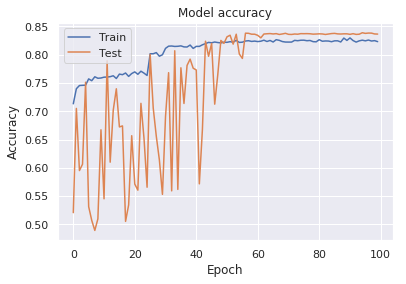

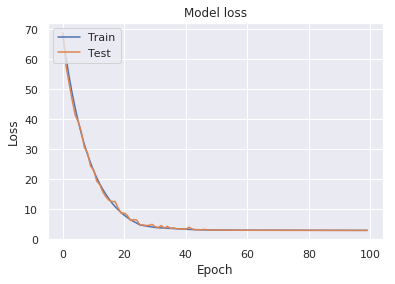

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
# use our model to predict
y_predict_encoded = model_lr.predict(X_test)


In [14]:
y_predict_encoded[:20]

array([[0.7657915 , 0.23420852],
       [0.85408026, 0.14591977],
       [0.12444682, 0.87555313],
       [0.14698349, 0.8530165 ],
       [0.20285918, 0.79714084],
       [0.6784358 , 0.3215642 ],
       [0.7738311 , 0.22616892],
       [0.27026987, 0.7297301 ],
       [0.30806115, 0.6919388 ],
       [0.17895266, 0.82104737],
       [0.45457998, 0.54542005],
       [0.733691  , 0.26630905],
       [0.9457318 , 0.05426824],
       [0.4923085 , 0.5076915 ],
       [0.04853345, 0.95146656],
       [0.00519617, 0.99480385],
       [0.791752  , 0.20824802],
       [0.02906916, 0.9709308 ],
       [0.1123685 , 0.88763154],
       [0.5603641 , 0.43963587]], dtype=float32)

In [15]:
y_predict = [row.idxmax() for index, row in pd.DataFrame(y_predict_encoded).iterrows()]
y_predict[:20]

[0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0]

In [16]:
print(classification_report(y_test, y_predict, target_names=["loss", "win"]))

              precision    recall  f1-score   support

        loss       0.84      0.83      0.84      7439
         win       0.83      0.85      0.84      7385

    accuracy                           0.84     14824
   macro avg       0.84      0.84      0.84     14824
weighted avg       0.84      0.84      0.84     14824



[[6153 1286]
 [1138 6247]]


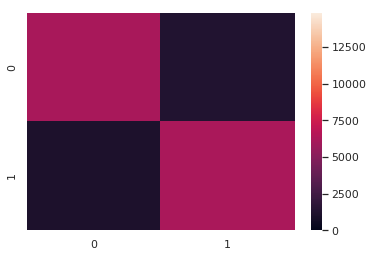

In [17]:
cm = confusion_matrix(y_test, y_predict)
print(cm)
sns.heatmap(cm, vmin=0, vmax=len(y_test))